In [397]:
import numpy as np
from pylab import show, imshow, cm
%pylab inline
from scipy.stats import logistic
from numpy.random import normal
from numpy.random import uniform
from math import log
from scipy.special import logit
#logit(p) = log(p / (1 - p))
sigmoid = logistic.cdf
from scipy.special import expit
#expit(x) = 1 / (1 + e^(-x))
from scipy.stats import bernoulli
from math import ceil
import pickle
from random import sample
import itertools

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Getting back the objects:
with open('objs.pickle', 'rb') as f:  # Python 3: open(..., 'rb')
    W, b, c = pickle.load(f)

In [1]:
def h_probas(W, c, v):
    n, m = W.shape
    return expit([np.dot(W[i], v) + c[i] for i in range(n)])

def h_proba(W, c, v, i, m):
    return expit(np.dot(W[i], v) + c[i])

In [405]:
sigma0 = 0.5
batch_size = 100
def train_RBM(m, n, data, iterations=1, k=1, W=None, b=None, c=None, learning_rate=0.1):
    #initialization
    if (W is None):
        W = np.array([[uniform(-4*np.sqrt(6/(n+m)), 4*np.sqrt(6/(n+m))) for j in range(m)] for i in range(n)])
    if (b is None):
        #b = np.array([logit(np.mean([v[j] for v in data])) for j in range(m)])
        b = np.zeros(m)
    if (c is None):
        c = np.zeros(n)
    #train
    for iteration in range(iterations):
        #print progress
        if (iteration % 50 == 0):
            if (iteration > 0):
                print()
            print(iteration, end=' '*(len(str(iterations)) - len(str(iteration)) + 1))
        
        S = sample(data, batch_size)
        dW = np.zeros((n, m))
        db = np.zeros(m)
        dc = np.zeros(n)
        for v in S:
            v0 = np.array(v)
            h0_probas = h_probas(W, c, v0)
            vk = np.array(v)
            for t in range(k):
                hk = bernoulli.rvs(h_probas(W, c, vk))
                vk = bernoulli.rvs(expit([np.dot(W[:,j], hk) + b[j] for j in range(m)]))
            hk_probas = h_probas(W, c, vk)
            db += v0 - vk
            dc += h0_probas - hk_probas
            v0.resize(1, len(v0))
            h0_probas.resize((len(h0_probas), 1))
            hk_probas.resize((len(hk_probas), 1))
            vk.resize(1, len(vk))
            dW += np.matmul(h0_probas, v0) - np.matmul(hk_probas, vk)
        
        W += learning_rate * dW
        b += learning_rate * db
        c += learning_rate * dc
        iteration += 1
        print('#', end='')
    return W, b, c

In [87]:
import dataReader
images, labels = dataReader.loadMinst("Data/train-labels.idx1-ubyte", "Data/train-images.idx3-ubyte", binary = True, lowDimenson = True)
images = list(images.reshape(len(images), 196))

In [500]:
W, b, c = train_RBM(len(images[0]), 500, images, iterations=200, W=W, b=b, c=c)

0   ##################################################
50  ##################################################
100 ##################################################
150 ##################################################

In [90]:
#initial_distribution = np.array([np.mean([v[j] for v in data]) for j in range(m)])

def generate(W, b, c, n, m, digit=-1, iterations=1):
    #v = sample(images, 1)[0]
    tail = [int(d==digit) for d in range(9)]
    v = [0.5 for j in range(m)]
    v[-9:] = tail
    for p in range(iterations):
        h = bernoulli.rvs(h_probas(W, c, v))
        v = bernoulli.rvs(expit([np.dot(W[:,j], h) + b[j] for j in range(m)]))
    return v

In [229]:
def classify(W, b, c, n, m, image):
    tail = [0 for i in range(9)]
    h = bernoulli.rvs(h_probas(W, c, image + tail))
    v = (expit([sum([W[i][j]*h[i] for i in range(n)]) + b[j] for j in range(-9, 0)]))
    print(v)
    return np.argmax(v)

In [312]:
W0 = W
b0 = b
c0 = c;

In [240]:
# Saving the objects:
with open('objs.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([W0, b0, c0], f)

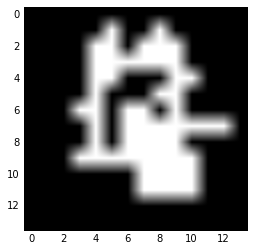

In [616]:
v = generate(W=W, b=b, c=c, n=500, m=len(images[0]), digit=0, iterations=2)
predicted_image = [[v[14*i + j] for j in range(14)] for i in range(14)]
imshow(predicted_image, cmap=cm.gray)
show()